In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import mne
from mne.io import read_raw_edf
from mne.decoding import CSP


from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
os.getcwd()

%matplotlib inline

/home/ambisinistra/miniconda3/envs/mne_pytorch/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ambisinistra/miniconda3/envs/mne_pytorch/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
directory = '/home/ambisinistra/workspace/EEG/RAW/edf/'

for root, dirs, files in os.walk(directory):
    print (root)
    for file in files:
        if (file.split('.')[-1] == 'edf'):
            raw = read_raw_edf(root + file, preload = True)
            break

/home/ambisinistra/workspace/EEG/RAW/edf/
Extracting EDF parameters from /home/ambisinistra/workspace/EEG/RAW/edf/Bondarenko_27_09_16_Edit Markers.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 292095  =      0.000 ...  1140.996 secs...


Effective window size : 8.000 (s)


<ipython-input-3-649b28c0284d>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  _ = raw.plot_psd()


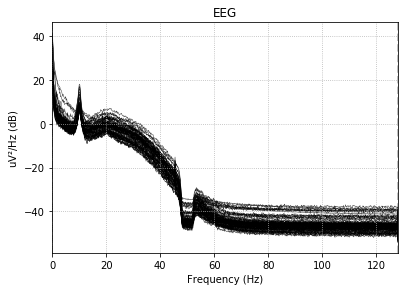

In [3]:
_ = raw.plot_psd() 
#[raw.plot_psd(picks=i) for i in raw.ch_names]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB



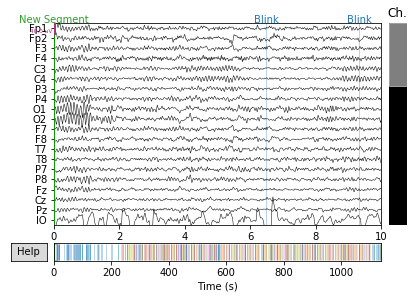

In [3]:
raw.filter(1, 20, method = "iir")
_ = raw.plot()

Effective window size : 8.000 (s)


<ipython-input-5-3a2892d888b1>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  _ = raw.plot_psd()


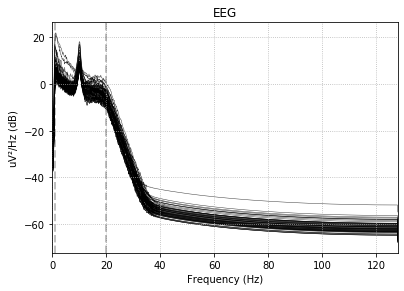

In [5]:
_ = raw.plot_psd()

In [5]:
#triyng smoothing over several epochs if needed

def apply_smoothing(epochs, smoothing=1):
    if smoothing != 1:
        truth = epochs["Truth"]
        new_truth = []
        new_labels = []
        for i in range(0, len(truth), smoothing):
            new_truth.append(truth[i:(i+smoothing)].average().data)
            new_labels.append(0)
        truth = np.stack(new_truth)
        lie = epochs["Lie"]
        new_lie = []
        for i in range(0, len(lie), smoothing):
            new_lie.append(lie[i:(i+smoothing)].average().data)
            new_labels.append(1)
        lie = np.stack(new_lie)
        data = np.concatenate((truth, lie), axis=0)
        labels = np.array(new_labels)
        epochs_data_train = (data - data.mean())/data.std()
    else:
        epochs_data_train = (epochs.get_data() - epochs.average().data) / epochs.standard_error().data
        labels = (epochs.events[:, 2] - 2)/7 #catching events with id's 2 and 7
        labels *= -1
        labels += 1
    return (epochs_data_train, labels)

In [9]:
decimation_factor = 5

events = mne.events_from_annotations(raw)

event_id = dict(Lie=2, Truth=9)

#TODO we can try to delete epochs with artifacts

epochs = mne.Epochs(raw, events[0], event_id, tmin = -0.1, tmax = 0.7, verbose=True, preload=True)

#epochs.decimate(decimation_factor)

#cross validation
cv = KFold(10, shuffle=True, random_state=42)
    
#TODO Isaichev asked to
#1 DONE try took several epochs and average em
#2 try discard +-2 sigma

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
151 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 151 events and 206 original time points ...
0 bad epochs dropped


    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-11-2134f57162e0>:1: DeprecationWarning: spatial_colors defaults to False in 0.19 but will change to True in 0.20. Set it explicitly to avoid this warning.
  _ = epochs['Lie'].plot_psd()
<ipython-input-11-2134f57162e0>:1: DeprecationWarning: average defaults to True in 0.19 but will change to False in 0.20. Set it explicitly to avoid this warning.
  _ = epochs['Lie'].plot_psd()


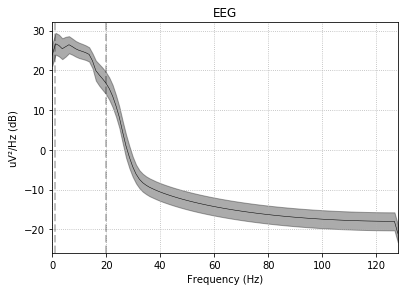

In [11]:
_ = epochs['Lie'].plot_psd()

    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-12-7bdabe069449>:1: DeprecationWarning: spatial_colors defaults to False in 0.19 but will change to True in 0.20. Set it explicitly to avoid this warning.
  _ = epochs['Truth'].plot_psd()
<ipython-input-12-7bdabe069449>:1: DeprecationWarning: average defaults to True in 0.19 but will change to False in 0.20. Set it explicitly to avoid this warning.
  _ = epochs['Truth'].plot_psd()


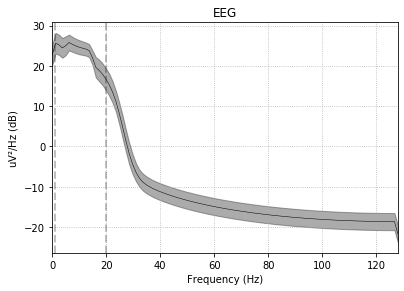

In [12]:
_ = epochs['Truth'].plot_psd()

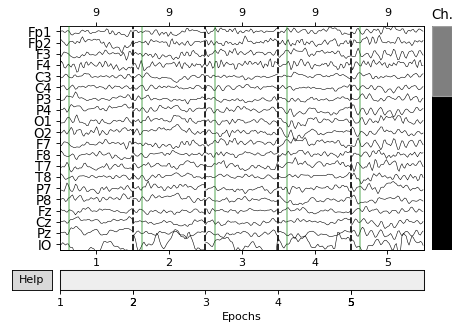

In [13]:
_ = epochs['Truth'][0:5].plot()

Loading data for 5 events and 180 original time points ...
Loading data for 5 events and 180 original time points ...


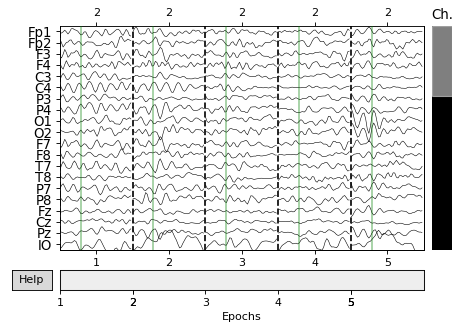

In [46]:
_ = epochs['Lie'][0:5].plot()

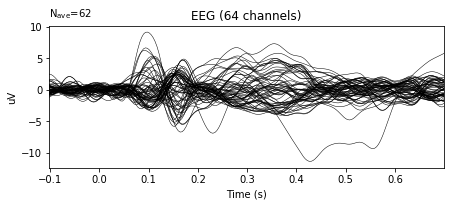

In [14]:
_ = epochs['Lie'].average().plot()

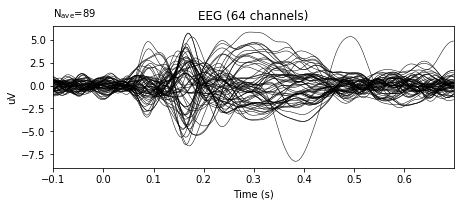

In [15]:
_ = epochs['Truth'].average().plot()

In [17]:
mdm = MDM(metric=dict(mean='riemann', distance='riemann'))

clf = TSclassifier()

# Assemble a classifier
lr = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=False)
clf_assembly = Pipeline([('CSP', csp), ('LogisticRegression', lr)])

np.random.seed(42)

In [26]:
# appling severeal smoothing 

mdm_score = []

clf_score = []

clf_assembly_score = []

for i in range(1, 8):
    
    print ("APPLYING SMOOTHING {}".format(i))
    
    epochs_data_train, labels = apply_smoothing(epochs, smoothing = i)
        
    # compute covariance matrices
    cov_data_train = Covariances(estimator='lwf').transform(epochs_data_train)
    
    # Use scikit-learn Pipeline with cross_val_score function
    scores = cross_val_score(mdm, cov_data_train, labels, cv=cv, n_jobs=4)

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("MDM Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    mdm_score.append(np.mean(scores))
    
    # Use scikit-learn Pipeline with cross_val_score function
    scores = cross_val_score(clf, cov_data_train, labels, cv=cv, n_jobs=4)

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Tangent space Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    clf_score.append(np.mean(scores))
    
    scores = cross_val_score(clf_assembly, epochs_data_train, labels, cv=cv, n_jobs=4)

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("CSP + LDA Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
    clf_assembly_score.append(np.mean(scores))

APPLYING SMOOTHING 1
MDM Classification accuracy: 0.756250 / Chance level: 0.589404
Tangent space Classification accuracy: 0.736250 / Chance level: 0.589404
CSP + LDA Classification accuracy: 0.629583 / Chance level: 0.589404
APPLYING SMOOTHING 2
MDM Classification accuracy: 0.776786 / Chance level: 0.592105
Tangent space Classification accuracy: 0.842857 / Chance level: 0.592105
CSP + LDA Classification accuracy: 0.750000 / Chance level: 0.592105
APPLYING SMOOTHING 3
MDM Classification accuracy: 0.803333 / Chance level: 0.588235
Tangent space Classification accuracy: 0.806667 / Chance level: 0.588235
CSP + LDA Classification accuracy: 0.610000 / Chance level: 0.588235
APPLYING SMOOTHING 4
MDM Classification accuracy: 0.850000 / Chance level: 0.589744
Tangent space Classification accuracy: 0.741667 / Chance level: 0.589744
CSP + LDA Classification accuracy: 0.483333 / Chance level: 0.589744
APPLYING SMOOTHING 5
MDM Classification accuracy: 0.791667 / Chance level: 0.580645
Tangent spac

In [27]:
print(mdm_score)
print()
print(clf_score)
print ()
print(clf_assembly_score)

[0.7562500000000001, 0.7767857142857143, 0.8033333333333333, 0.85, 0.7916666666666667, 0.8333333333333333, 0.9166666666666666]

[0.7362500000000001, 0.8428571428571429, 0.8066666666666666, 0.7416666666666667, 0.8833333333333332, 0.8333333333333333, 0.8166666666666667]

[0.6295833333333334, 0.7499999999999999, 0.6100000000000001, 0.4833333333333333, 0.6833333333333333, 0.6, 0.7]


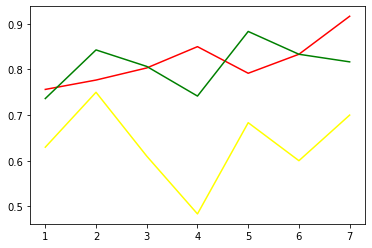

In [30]:
n = np.array(range(1, len(mdm_score)+1))

plt.plot(n, np.array(mdm_score), label='mdm', color='red')
plt.plot(n, np.array(clf_score), label='clf', color='green')
plt.plot(n, np.array(clf_assembly_score), label='assembly', color='yellow')
plt.show()

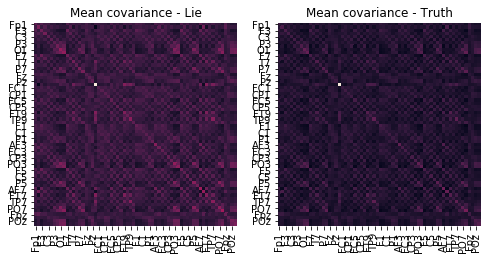

In [31]:
epochs_data_train, labels = apply_smoothing(epochs, smoothing = 3)
        
    # compute covariance matrices
cov_data_train = Covariances(estimator='lwf').transform(epochs_data_train)

mdm = MDM()
mdm.fit(cov_data_train, labels)

fig, axes = plt.subplots(1, 2, figsize=[8, 4])
ch_names = [ch.replace('.', '') for ch in epochs.ch_names]

df = pd.DataFrame(data=mdm.covmeans_[0], index=ch_names, columns=ch_names)
g = sns.heatmap(df, ax=axes[0], square=True, cbar=False, xticklabels=2,
                yticklabels=2)
g.set_title('Mean covariance - Lie')

df = pd.DataFrame(data=mdm.covmeans_[1], index=ch_names, columns=ch_names)
g = sns.heatmap(df, ax=axes[1], square=True, cbar=False, xticklabels=2,
                yticklabels=2)
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
g.set_title('Mean covariance - Truth')

# dirty fix
plt.sca(axes[0])
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.show()